# Visualizing Overfitting and Model Complexity

In [1]:
%load_ext autoreload
%autoreload 2

import sys

from dataclasses import dataclass
from typing import Union

from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.utils.splits import train_test_split
from AppliedML.courselib.optimizers import GDOptimizer
import AppliedML.courselib.models.nn as nn
import AppliedML.courselib.models.svm as svm
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.Spirals as sp

from models.TunableModel import TunableModel
from models.TunableNN import TunableNN
from models.TunableKernelSVM import TunableKernelSVM
from models.TunableRandomForest import TunableRandomForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:

@dataclass
class ExperimentConfig:
    tunable_model: TunableModel
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    training_params: Union[dict, callable]
    title_generator: callable
    encode_label: callable
    measure_accuracy: callable


In [3]:
def train_tunable_model(cf):
    models = cf.tunable_model.fit(
        X = cf.train_df[['x', 'y']].to_numpy(),
        y = cf.encode_label(cf.train_df['label']),
        training_params = cf.training_params,
    )
    
    has_metrics = len(history for _, _, history in models if history is not None) > 0
    if not has_metrics:
        return models
    
    fig, axs = plt.subplots(1, len(models), figsize=(8*len(models), 8))
    if len(models) == 1:
        axs = np.array([axs])
        
    for ax, (model, params, metrics_history) in zip(axs.flat, models):
        ax.set_title(cf.title_generator(params))
        ax.set(aspect='equal')
        
        if metrics_history is None:
            ax.text(0.5, 0.5, "No metrics available", horizontalalignment='center', verticalalignment='center')
            continue
        
        xs = range(len(metrics_history['accuracy']))
        acc = metrics_history['accuracy']
        loss = metrics_history['loss']
        
        ax.plot(xs, acc, color='blue')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        
        ax2 = ax.twinx()
        ax2.plot(xs, loss, color='orange')
        ax2.set_ylabel('Loss')
        
    plt.tight_layout()
    plt.show()

In [4]:
def show_tunable_model(cf, trained_models):
    fig, axs = plt.subplots(1, len(trained_models), figsize=(8*len(trained_models), 8))
    if len(trained_models) == 1:
        axs = np.array([axs])
        
    df = pd.concat([cf.train_df, cf.test_df])
    
    x_min, x_max = df['x'].min() - 0.5, df['x'].max() + 0.5
    y_min, y_max = df['y'].min() - 0.5, df['y'].max() + 0.5
    
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    
    num_train_samples = len(cf.train_df)
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, (model, params, _) in zip(axs.flat, trained_models):
        ax.set_title(cf.title_generator(params))
        ax.set(aspect="equal")  
        
        h_list = model(X_list)
        
        acc_train = cf.measure_accuracy(model, cf.train_df)
        acc_test = cf.measure_accuracy(model, cf.test_df)
        
        ax.text(0.5, -0.1, f"Final train accuracy: {acc_train:.1f}%\nTest accuracy: {acc_test:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        
        ax.scatter(cf.test_df['x'], cf.test_df['y'], c=colors_test, edgecolor='k', alpha=0.3, s=5)
        ax.scatter(cf.train_df['x'], cf.train_df['y'], c=colors_train, edgecolor='k')
        
    plt.tight_layout()
    plt.show()

Seed used: 40733704


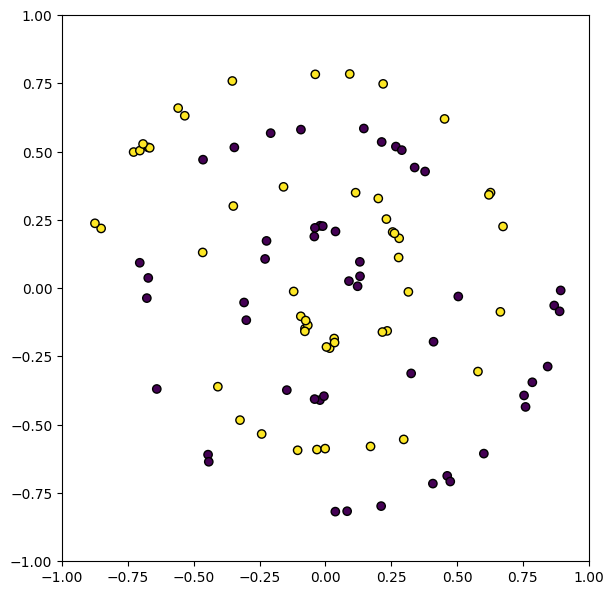

In [5]:
my_seed = 40733704 #int(random.random()*100000000)
np.random.seed(my_seed)
print("Seed used:", my_seed)

gen = sp.Spirals(sp.SpiralConf(2, 0.05, 0.1, 0.9, 2))
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2)),
#                     hm.HalfMoonConf(angle_range=(3.14,6.29), centre=(0.2,0.2))])
#gen = cc.ConcentricBands()#[cc.CBandConf(0.7, 0.5)])
# gen = sb.RandomSeparatedBlobs()
df = gen.sample(num_samples=100)

plt.figure(figsize=(6, 6))

colors = df['label'].astype("category").cat.codes
plt.scatter(df['x'], df['y'], c=colors, edgecolor='k')

plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

## Perceptrons

In [6]:
def get_optimizer(params):
    if params['activation'] == 'ReLU':
        return GDOptimizer(learning_rate=0.5)
    else:
        return GDOptimizer(learning_rate=5)

params = {
    # 'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [1,8,16])),
    'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [1,2])),
    'activation': ["ReLU"],
    'optimizer': get_optimizer
}

tunable_model = TunableNN(
    hyperparameters=params
)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

num_batches = 5
training_params = {
    'num_epochs': 1000,
    'batch_size': (len(df)*train_split) // num_batches,
    'compute_metrics': True,
    'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}
}

title_generator = lambda params: f"Width: {params['widths']}"
encode_label = lambda ls: labels_encoding(ls.to_numpy())

measure_accuracy = lambda model, df: \
    accuracy(
        model(df[['x', 'y']].to_numpy()), 
        encode_label(df['label'])
    )
    
config = ExperimentConfig(
    tunable_model=tunable_model,
    train_df=train_df,
    test_df=test_df,
    training_params=training_params,
    title_generator=title_generator,
    encode_label=encode_label,
    measure_accuracy=measure_accuracy
)

In [ ]:
trained_models = train_tunable_model(config)

In [ ]:

label_to_num_label = lambda ls: labels_encoding(ls.to_numpy())
measure_accuracy = (lambda model, df:
                      accuracy(model.decision_function(df[['x', 'y']].to_numpy()), 
                               label_to_num_label(df['label'])))
params_to_title = lambda params: f"Width: {params['widths']}"


df = gen.sample(num_samples=1000)
train_split = 0.2
num_batches = 5
num_epochs = 10000

show_tunable_model(tunable_model,
                   df,
                   params_to_title,
                   label_to_num_label,
                   measure_accuracy,
                   train_split=train_split,
                   training_params={'num_epochs': num_epochs,
                                    'batch_size': (len(df)*train_split)//num_batches,
                                    'compute_metrics': True,
                                    'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}})

## Kernel SVM

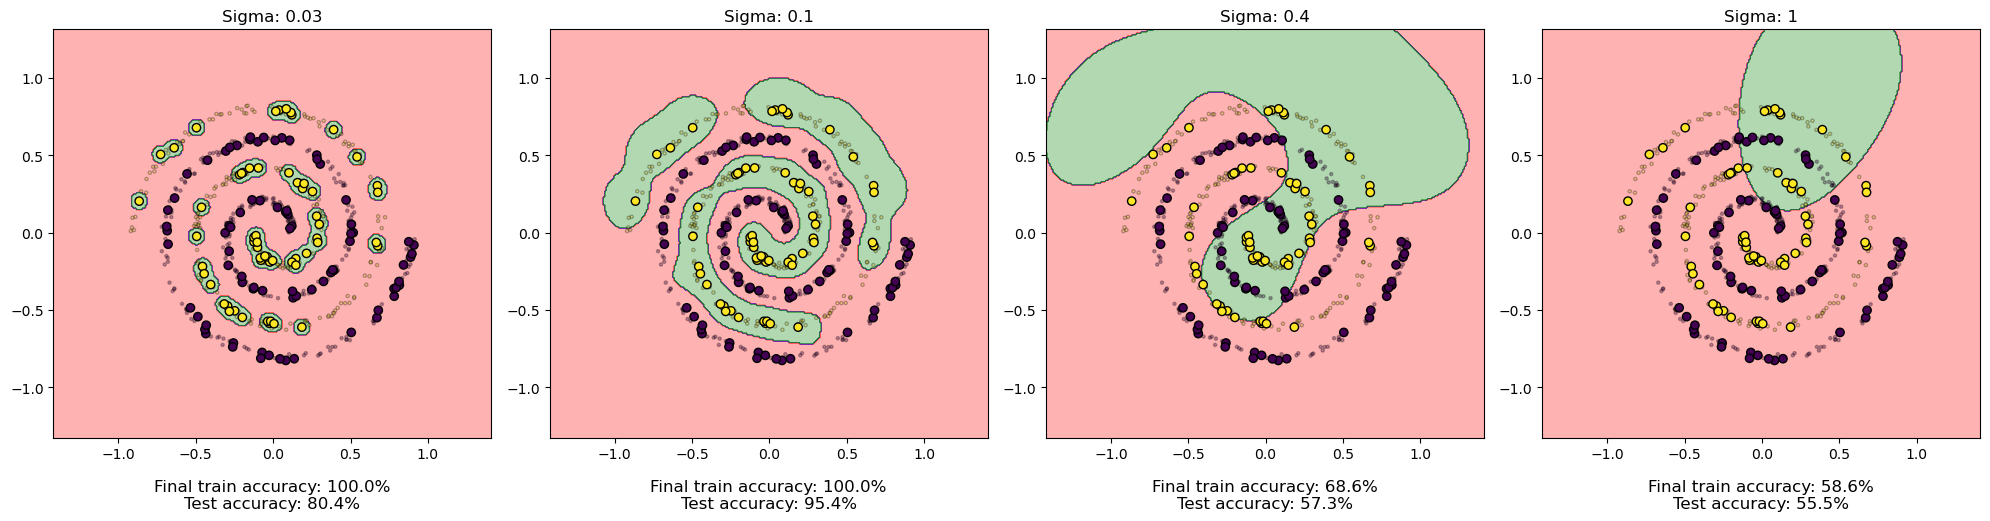

In [5]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.03,0.1,0.4,1],
    'degree': range(1),
    'intercept': range(3),
}

label_to_num_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1
measure_accuracy = (lambda model, df: accuracy(model(df[['x', 'y']].to_numpy()),
                                               label_to_num_label(df['label']),
                                               False))
params_to_title = lambda params: f"Sigma: {params['sigma']}"

tunable_model = TunableKernelSVM(
    hyperparameters=params,
)

df = gen.sample(num_samples=700)
show_tunable_model(tunable_model, df, params_to_title, label_to_num_label, measure_accuracy)

## Decision Trees